In [79]:
import numpy as np

import random
import datetime

from gensim.models import Word2Vec
from nltk import word_tokenize, sent_tokenize

import tensorflow as tf
import tensorflow.contrib.rnn as rnn

import matplotlib.pyplot as plt

In [2]:
np.random.seed(2018)

In [3]:
txt = open("theLordOfTheRings.txt", 'r')
data = txt.read()
data = data.lower()

In [4]:
sentences = sent_tokenize(data)
words = word_tokenize(data)

In [5]:
sentences_break_down = [word_tokenize(sentence) for sentence in sentences] 

In [6]:
emb_dim = 300 # length of each word vector

In [7]:
model = Word2Vec(sentences_break_down,
                 sg=1,
                 size=emb_dim,
                 window=3,
                 alpha=0.0005,
                 min_count=1,
                 workers=8,
                 batch_words=1500
                 )

In [8]:
vocab_size = len(list(model.wv.vocab))
print(vocab_size)

vocab = list(model.wv.vocab.keys())

9870


In [9]:
model.train(sentences_break_down, total_words=vocab_size, epochs=250)

(37466189, 54575500)

In [10]:
model.wv.most_similar(positive="merry")

[('boromir', 0.9888407588005066),
 ('aragorn', 0.9885234236717224),
 ('gimli', 0.9864516258239746),
 ('legolas', 0.9828614592552185),
 ('pippin', 0.9820834994316101),
 ('sam', 0.9729862213134766),
 ('strider', 0.9723973274230957),
 ('haldir', 0.9661816954612732),
 ('tom', 0.9613646864891052),
 ('butterbur', 0.9604867696762085)]

In [11]:
idWordsDict = dict((Id, word) for Id, word in enumerate(vocab))
wordsIdDict = dict((word, Id) for Id, word in enumerate(vocab))
idVectDict = dict((Id, vect.reshape(1,len(vect))) for Id, vect in enumerate(model.wv[vocab]))   # length of the 3 dictionaries: 10883

In [33]:
# sample a word from the distribution of a predicted probability
# "prediction" is of shape (1, vocab_size)
def sample(prediction):
    r = random.uniform(0,1)
    s = 0
    word_id = 0
    for i in range(len(prediction[0])):
        s += prediction[0,i]
        if s >= r:
            word_id = i
            break
    return word_id

In [65]:
section_len = 12 # group words as a section
skip = 10
sections = []
labels = []
for i in range(0, len(words)-section_len, skip):
    sections.append(words[i:i+section_len])
    labels.append(words[i+section_len])

In [66]:
nb_sections = len(labels)

history_words = np.zeros((nb_sections, section_len, emb_dim))
current_words = np.zeros((nb_sections, vocab_size))

for i in range(nb_sections):
    history_words[i,:,:] = model.wv[sections[i]]
    current_words[i,wordsIdDict[labels[i]]] = 1

In [67]:
history_words.shape

(43659, 10, 300)

In [68]:
current_words.shape

(43659, 9870)

In [73]:
# Gru generating network settings
batch_size = 400
hidden_nodes = 2048
nb_iter = 3000    # this is NOT the nb of epochs, it is the nb of batches to run in the training process
lr = 0.002
proba = 0.5
nb_layers = 2
log_every = 50
checkpoint_every = 100
checkpoint_directory = 'checkpts2'

In [74]:
# create checkpoints dir.
if tf.gfile.Exists(checkpoint_directory):
    tf.gfile.DeleteRecursively(checkpoint_directory)
tf.gfile.MkDir(checkpoint_directory)    

In [76]:
# build graph

graph = tf.Graph()
with graph.as_default():
    
    '''
    placeholders
    '''
    train_data = tf.placeholder(tf.float32, [batch_size, section_len, emb_dim])
    train_labels = tf.placeholder(tf.float32, [batch_size, vocab_size])
    
    test_data = tf.placeholder(tf.float32, shape=[1,section_len, emb_dim])
    
    keep_proba = tf.placeholder(tf.float32)
    
    
    
    '''
    define global step and GRU-Dropout cell
    '''
    global_step = tf.Variable(0)
    
    def GRU_Dropout(nb_hidden_nodes, keep_prob):
        cell = rnn.GRUCell(nb_hidden_nodes)
        cell = rnn.DropoutWrapper(cell,output_keep_prob=keep_prob)
        return cell
    
    
               
    '''
    GRU_Dropout layer feed forward
    '''
    # 2 layers: [GRU , Dropout] -> [GRU , Dropout]
    stacked_GRUs = rnn.MultiRNNCell([GRU_Dropout(hidden_nodes, keep_proba) for _ in range(nb_layers)],
                                    state_is_tuple=True)
    init_state = stacked_GRUs.zero_state(batch_size, dtype=tf.float32)

    state = init_state
    output = tf.zeros([batch_size, hidden_nodes])
    for i in range(section_len):
        output, state = stacked_GRUs(train_data[:,i,:],state)
    
    '''
    fully connected layer feed forward
    ''' 
    w = tf.Variable(tf.truncated_normal([hidden_nodes, vocab_size], -0.3, 0.3))
    b = tf.Variable(tf.zeros([vocab_size]))
    
    
    '''
    train
    '''
    predictions = tf.matmul(output, w) + b
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=train_labels, logits=predictions))
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)
    
    
    
    '''
    test
    '''
    test_state = stacked_GRUs.zero_state(1, dtype=tf.float32)
    test_output = tf.Variable(tf.zeros([section_len, hidden_nodes]))
    

    for i in range(section_len):
        test_output, test_state = stacked_GRUs(test_data[:,i,:], test_state)
        
        
    test_prediction = tf.nn.softmax(tf.matmul(test_output, w) + b)
    

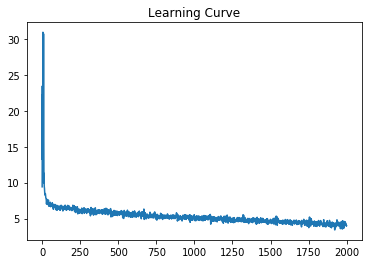

In [80]:
with tf.Session(graph=graph) as sess:

    tf.global_variables_initializer().run()
    offset = 0
    saver = tf.train.Saver()
    
    losses = []
    
    hist_len = len(history_words)
    
    # for each training step
    for step in range(nb_iter):
        
        # starts off as 0
        offset = offset % hist_len
        
        # calculate batch data and labels to feed model iteratively
        if offset <= (hist_len - batch_size):
            # first parts
            batch_data = history_words[offset: offset + batch_size]
            batch_labels = current_words[offset: offset + batch_size]
            offset += batch_size

        else:
            # the last part
            to_add = batch_size - (hist_len - offset)
            batch_data = np.concatenate((history_words[offset: hist_len], history_words[0: to_add]))
            batch_labels = np.concatenate((current_words[offset: hist_len], current_words[0: to_add]))
            offset = to_add
        
        _, training_loss = sess.run([optimizer, loss], feed_dict={train_data: batch_data, train_labels: batch_labels, 
                                                                  keep_proba: proba})
        losses.append(training_loss)
        
        if step % 20 == 0:
            print('training loss at step %d: %.3f (%s)' % (step, training_loss, datetime.datetime.now()))

            if step % checkpoint_every == 0:
                saver.save(sess, checkpoint_directory + '/model', global_step=step)
    print('training loss at step %d: %.2f (%s)' % (nb_iter, training_loss, datetime.datetime.now()))

    plt.plot(np.arange(nb_iter), losses)
    plt.title('Learning Curve')
    plt.show()

In [81]:
test_start = 'gandalf was reading the riddle written on the stone in elvish and has understood nothing but '

In [82]:
with tf.Session(graph=graph) as sess:
    #init graph, load model
    tf.global_variables_initializer().run()
    model_tf = tf.train.latest_checkpoint(checkpoint_directory)
    saver = tf.train.Saver()
    saver.restore(sess, model_tf)

    #set input variable to generate chars from
    #reset_test_state.run() 
    test_generated = test_start
    
    tokenized_start = word_tokenize(test_start)
    test_X = model.wv[tokenized_start[-section_len:]]

    generated_len = 200
    counter = 1
    while counter <= generated_len:
        # Attention: in the test phase, reset the keep_proba to 1 
        prediction = sess.run(test_prediction, feed_dict={test_data: test_X.reshape((1,section_len,emb_dim)), 
                                                          keep_proba: 1.0})
        word_id = sample(prediction)
        
        next_word = idWordsDict[word_id]
        test_generated += (next_word + ' ')
        
        test_X = np.concatenate([test_X, idVectDict[word_id]], axis=0)[1:]
        
        counter += 1
         
    print(test_generated)

INFO:tensorflow:Restoring parameters from checkpts2/model-1900
gandalf was reading the riddle written on the stone in elvish and has understood nothing but 'strider to strands fleeing ' said gandalf , and pippin looked out . 'now soon did hear what if them , ' said gandalf . 'neither have been the fortnight place in the minds of men . the return mountains mountains they windings grows against the dark and naked ; and the lingering grew the eastern in the night . the river was fetched of snow in the night , and without the secrecy . ’ he said . 'you must you have been here , but come , break may day gimli , and the others have come to look on the ground . we can send telling on again . i can get in perhaps the land , and we want get in hobbiton , and the paths in the mountains above the wild land in the return ; glistening of black folk , lantern-light shone bofur of the men , and those for them movements to ground as long in the flies . it was weary well hale , elrond was sinking of ea